# 41934 Advanced BIM - A2
#### **Authors**:
Rihards Zamoidiks, s186415  
Eliza Anna Grinberga, s223262


Welcome to this commentary notebook!  
Here, we provide a more detailed narrative to accompany the script developed for our tool in A2, enhancing your learning experience as you explore the tool's functionality and implementation.  

**NOTE:** This script has minor, non-operational changes compared to the original Python script, to ensure compatibility with Jupyter Notebooks.

To kick things off, let's import all the necessary Python libraries essential for the operation of this tool:

In [32]:
from pathlib import Path
import ifcopenshell  
import pandas as pd  
import openpyxl

In this section of the script, we've defined several functions to handle repetitive tasks.  
The first one, named `loadFile`, is responsible for loading an IFC file. When you run this function, it will ask you to input the name of the IFC file you want to load. If you press Enter without typing anything, it will default to a file named 'LLYN - STRU.ifc', which has been commonly used during this course.

**Note:** To ensure successful loading, place the IFC file in the designated `model` folder. 

The function checks if the specified file exists. If it does, it loads the file and returns two pieces of information: the loaded model and its name. If the file is not found, it gives an error message.

Here's how the function looks in Python:

In [34]:
def loadFile():
    # Specify the name of the IFC model
    modelname = input("Enter the IFC model name (or press Enter for default 'LLYN - STRU'): ")
    
    # Set a default value if the user didn't provide input
    if not modelname:
        modelname = 'LLYN - STRU'
    
    try:
        dir_path = Path.cwd()
        model_url = Path.joinpath(dir_path, 'model', modelname).with_suffix('.ifc')
        model = ifcopenshell.open(model_url)
    except OSError:
        try:
            # If file not found, bpy import will produce an error, if script is run outside of Blender
            import bpy
            model_url = Path.joinpath(Path(bpy.context.space_data.text.filepath).parent, 'model', modelname).with_suffix('.ifc')
            model = ifcopenshell.open(model_url)
        except OSError:
            print(f'ERROR: please check your model folder : {model_url} does not exist')
    
    # Load the IFC model
    model = ifcopenshell.open(model_url)
    
    return model, modelname

The following function, called `quantityTakeOff` extracts relevant quantities, such as volume and area, from load-bearing structural elements in an IFC model. The calculated data is stored in a pandas DataFrame and can be further analyzed for floorwise summaries and total quantities. The function also checks if the provided IFC model contains the specified structural elements. 

For a more detailed, step-by-step walk through, please refer to the comments embedded within the script.

In [35]:
def quantityTakeOff(element):
    # Retrieve IFC elements of the specified type
    str_elements = model.by_type(str(element))
    tot_elements = len(str_elements)
    
    # Create an empty pandas DataFrame with column titles
    columns = ['Floor', 'Volume, m3', 'Area, m2', 'Material']
    df = pd.DataFrame(columns=columns)

    # Check if the IFC model contains specified structural elements
    if len(str_elements) != 0:
       # Iterate through elements of the specified type
        for str_element in str_elements:
            if str_element.IsDefinedBy:
                definitions = str_element.IsDefinedBy
    
                is_load_bearing = False  # Initialize the load-bearing flag
    
                for definition in definitions:
                    # Check if the relationship is of type 'IfcRelDefinesByProperties'
                    if definition.is_a('IfcRelDefinesByProperties'):
                        property_definition = definition.RelatingPropertyDefinition
    
                        # Check if the element is load-bearing (assuming 'LoadBearing' property)
                        if property_definition.is_a('IfcPropertySet'):
                            for property in property_definition.HasProperties:
                                if property.Name == 'LoadBearing':
                                    # Check if the property value is True
                                    if property.NominalValue.wrappedValue == True:
                                        is_load_bearing = True  # Set the flag to True and break
                                        break  # Exit the property loop once load-bearing is confirmed
    
                # If the element is load-bearing, proceed to calculate quantities
                if is_load_bearing:
                    floor_name = str_element.ContainedInStructure[0].RelatingStructure.Name
                    
                    # Create a dictionary to store data for a DataFrame entry
                    element_properties = {
                        'Floor': floor_name,
                        'Volume': None,
                        'Area': None,
                        'Material': None
                    }
    
                    for definition in definitions:
                        # Check if the relationship is of type 'IfcRelDefinesByProperties'
                        if definition.is_a('IfcRelDefinesByProperties'):
                            property_definition = definition.RelatingPropertyDefinition
    
                            if property_definition.is_a('IfcElementQuantity'):
                                for quantity in property_definition.Quantities:
                                    
                                    # Check if the quantity is of type 'IfcQuantityArea'
                                    if quantity.is_a('IfcQuantityArea'):
                                        
                                        # Slab area, m2
                                        if quantity.Name == 'NetArea':
                                            element_properties['Area, m2'] = quantity.AreaValue
                                            
                                        # Wall surface area, m2
                                        elif quantity.Name == 'NetSideArea':
                                            element_properties['Area, m2'] = quantity.AreaValue
                                            
                                        # Beam surface area, m2
                                        elif quantity.Name == 'NetSurfaceArea':
                                            element_properties['Area, m2'] = quantity.AreaValue
                                            
                                    # Check if the quantity is of type 'IfcQuantityVolume' 
                                    elif quantity.is_a('IfcQuantityVolume'):
                                        
                                        # Element volume, m3
                                        if quantity.Name == 'NetVolume':
                                            element_properties['Volume, m3'] = quantity.VolumeValue
    
                    # Append the data as a new row to the pandas DataFrame
                    df = pd.concat([df, pd.DataFrame([element_properties], columns=columns)], ignore_index=True)
                    
                    # Create a floorwise summary:
                    floorwise_sum = df.groupby('Floor')[['Volume, m3', 'Area, m2']].sum()
                    
                    # Calculate total quantities for the specified element type
                    total_volume = df['Volume, m3'].sum()
                    total_area = df['Area, m2'].sum()
                

    return df, tot_elements, floorwise_sum, total_volume, total_area, element

The `report` function is designed to generate a comprehensive Excel report based on the analysis results. It takes as input the floorwise summary, total quantities, and the name of the IFC model. The function creates a new Excel workbook based on a template, inserts relevant data, and saves the report in the specified output directory. The generated report provides a structured and organized overview of the analyzed structural elements, making it a valuable tool for further analysis and decision-making.

As before, for a more detailed walk-through, refer to the comments within the script.

In [36]:
def report(floorwise_summary, tot_quantities, modelname):

    # Concatenate floorwise summary results
    summary = pd.concat(floorwise_summary, axis=1).round(2)
    
    # Reset the index to apply numerical indexing and make the "Floor" index an actual column
    summary.reset_index(level=0, inplace=True)
    summary.index += 1  # Add 1 to the index to start indexing from 1

    # Rename the columns to distinguish duplicate names
    summary.columns = [f'{col} {i}' for i, col in enumerate(summary.columns)]
    
    # Convert to DataFrame
    tot_quantities = pd.DataFrame([tot_quantities])
    
    # Load template and save a report file
    wb_temp = openpyxl.load_workbook('./input/rep_template.xlsx')
    wb_temp.save('./output/' + "report_" + modelname + '.xlsx')

    report_file_path = './output/' + "report_" + modelname + '.xlsx'
    wb_rep = openpyxl.load_workbook(report_file_path)

    # Create space for reported quantities while maintaining template layout
    for i in range(1,len(summary)): 
        wb_rep['Sheet1'].insert_rows(6) # number indicates insertion point
    
    # Add index column
    for i in range(1,len(summary)+1): 
        wb_rep['Sheet1'].cell(row=5+i, column=2).value = i 

    # Insert IFC file name
    wb_rep['Sheet1'].cell(row=3, column=3).value = modelname + ".ifc"
    wb_rep.save(report_file_path)
    
    # Create a Pandas ExcelWriter to append data
    with pd.ExcelWriter(report_file_path, engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:

        # Write the DataFrame to the Excel file on 'Sheet1'
        summary.to_excel(writer, sheet_name='Sheet1', index=False, header=False, startrow=5, startcol=2)
        tot_quantities.to_excel(writer, sheet_name='Sheet1', index=False, header=False, startrow=5+len(summary), startcol=3)

    # Inform about the completion and storage location
    print("Report has been exported to an Excel file:", report_file_path)
    
    return 

Below is an illustrative output example generated from the 'LLYN - STRU.ifc' file:

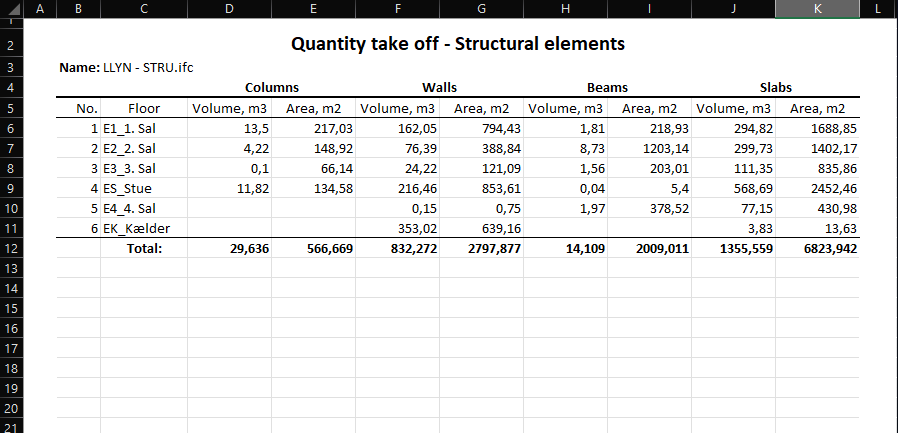

Now that we've defined the necessary functions, let's look into the structure of the main parts of the script, beginning with the initial step of loading the file:

In [38]:
# Load the IFC model
model, modelname = loadFile() 

Enter the IFC model name (or press Enter for default 'LLYN - STRU'):  LLYN - STRU


The upcoming parts of the script will initiate the generation of an initial written report within Python's console, starting with a floor overview:

In [39]:
# Output a written report within Python's console:  

# Collect floor names from the IFC model
floorNames = []

for entity in model.by_type('IfcBuildingStorey'):
    floorNames.append(entity.Name)

print('\nThere are', len(floorNames), 'floors in the model: \n')

# Print the names of each floor
for floor in floorNames:
    print(floor)


There are 6 floors in the model: 

EK_Kælder
ES_Stue
E1_1. Sal
E2_2. Sal
E3_3. Sal
E4_4. Sal


For this tool, our primary focus is on common types of structural elements, including Columns, Walls, Beams, and Slabs. Subsequently, we define the Ifc elements accordingly for further iterations.

In [40]:
# List of structural element types to be reported
elements = ['IfcColumn', 'IfcWall', 'IfcBeam', 'IfcSlab']

To store the results obtained for each story, we initialize lists for each type of result:

In [41]:
# Initialize lists for result storage:
element_summary = []        # list of DataFrames for each element
floorwise_summary = []      # list of DataFrames for floorwise summaries
tot_quantities = []         # total quantities by element type

Subsequently, we iterate through each type of structural element, as defined in the previous steps, and report the results in Python's console.

In [42]:
# Process each structural element type
for element in elements:
    element_quantities, tot_elements, floorwise_sum, total_volume, total_area , element = quantityTakeOff(element)
    
    # Add results to the lists
    element_summary.append(element_quantities)
    floorwise_summary.append(floorwise_sum)
    tot_quantities.append(total_volume)
    tot_quantities.append(total_area)
    
    # Print a report in Python's console
    print('________________________________________________________________')
    print('\nOut of', tot_elements, element, 'elements', len(element_quantities), 'are load bearing (structural).')
    print('\nFloorwise summary for', element,' elements: \n')
    print(floorwise_sum, '\n')
    print('Total material quantities for', element, 'elements:')
    print('Volume: ', round(total_volume,2), 'm3')
    print('Surface Area: ', round(total_area,2), 'm2')

________________________________________________________________

Out of 452 IfcColumn elements 452 are load bearing (structural).

Floorwise summary for IfcColumn  elements: 

           Volume, m3  Area, m2
Floor                          
E1_1. Sal      13.502   217.030
E2_2. Sal       4.217   148.919
E3_3. Sal       0.099    66.136
ES_Stue        11.818   134.584 

Total material quantities for IfcColumn elements:
Volume:  29.64 m3
Surface Area:  566.67 m2
________________________________________________________________

Out of 378 IfcWall elements 368 are load bearing (structural).

Floorwise summary for IfcWall  elements: 

           Volume, m3  Area, m2
Floor                          
E1_1. Sal     162.047   794.433
E2_2. Sal      76.386   388.835
E3_3. Sal      24.217   121.091
E4_4. Sal       0.152     0.752
EK_Kælder     353.015   639.160
ES_Stue       216.455   853.606 

Total material quantities for IfcWall elements:
Volume:  832.27 m3
Surface Area:  2797.88 m2
____________

Upon completion of the script's analysis, you will be promted to generate an Excel workbook report, as presented at the beginning. Once a selection is made, the tool has finished its operation.

In [43]:
# Generate a spreadsheet report
while True: 
    prompt = input("\nDo you want to generate a spreadsheet report? (Enter 'y' for Yes, 'n' for No): ")
    
    if prompt == 'y':   
        report(floorwise_summary, tot_quantities, modelname)
        break
    elif prompt == 'n':
        print("Exiting without generating a report.")
        break
    else:
        print("Invalid input. Please enter 'y' or 'n'.")  


Do you want to generate a spreadsheet report? (Enter 'y' for Yes, 'n' for No):  y


Report has been exported to an Excel file: ./output/report_LLYN - STRU.xlsx
